# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [124]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [125]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [126]:
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'
else:
    symbol_list = 'all'

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    minimum_feature_threshold = 0.9
    param_grid = {
            'shuffle': [True], 
            'solver': ['adam'], 
            'learning_rate': ['adaptive'],
            'tol': [0.0001],
            'max_iter': [200],
            'alpha': [0.0001],
            'hidden_layer_sizes': [ast.literal_eval(input('Hidden Layers: eg. "(100, 100), (500, 500)"'))],
            'learning_rate_init': [0.001],
            'n_iter_no_change': [9]
        }
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [127]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
if symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist() 
symbols = symbols + \
    pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAN', ..., 'IQ', 'SYDB.CO', 'UBER'], dtype=object)

#### Download annual financial data

In [128]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) == 5 or ticker_df.isna().sum().sum() >= round(352 * minimum_feature_threshold):
                print(f'{symbol}: True')
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                print(f'{symbol}: False')
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [129]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dividends Received Cfi,Change In Accrued Expense,Short Term Debt Payments,Unrealized Gain Loss On Investment Securities,Net Preferred Stock Issuance,Preferred Stock Issuance,Duefrom Related Parties Non Current,Loans Receivable,Dueto Related Parties Non Current,Non Current Note Receivables
0,MATAS.CO,2024-12-31,NaN,NaN,NaN,Consumer Cyclical,Specialty Retail,3.770000e+08,-2.700000e+07,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATAS.CO,2024-03-31,0.006267,0.065357,0.159205,Consumer Cyclical,Specialty Retail,2.390000e+08,-2.100000e+07,-1.890000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MATAS.CO,2023-03-31,0.014033,0.205079,0.459568,Consumer Cyclical,Specialty Retail,4.240000e+08,0.000000e+00,-1.260000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MATAS.CO,2022-03-31,-0.211179,-0.301726,-0.110513,Consumer Cyclical,Specialty Retail,3.271000e+08,-7.510000e+07,-7.084000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MATAS.CO,2021-03-31,0.391748,0.478732,0.209816,Consumer Cyclical,Specialty Retail,8.036000e+08,0.000000e+00,-7.250000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RNMBY,2025-03-31,NaN,NaN,NaN,Industrials,Aerospace & Defense,2.670000e+08,NaN,-4.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RNMBY,2023-12-31,0.768973,0.616452,1.071535,Industrials,Aerospace & Defense,3.450000e+08,NaN,-4.850000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RNMBY,2022-12-31,0.493045,0.398488,0.633525,Industrials,Aerospace & Defense,-1.750000e+08,NaN,-2.320000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RNMBY,2021-12-31,1.329688,1.491433,1.219995,Industrials,Aerospace & Defense,4.190000e+08,NaN,-2.310000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,RNMBY,2020-12-31,-0.075638,-0.041881,-0.106959,Industrials,Aerospace & Defense,2.140000e+08,NaN,-3.605000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Removal of low datapoint columns

In [130]:
# columns_to_remove = [col for col in df.columns if df[col].notna().sum() < feature_amount]

# df = df.drop(columns=columns_to_remove)
# print(columns_to_remove)
# df

### Impution and encoding

In [131]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [132]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dividends Received Cfi,Change In Accrued Expense,Short Term Debt Payments,Unrealized Gain Loss On Investment Securities,Net Preferred Stock Issuance,Preferred Stock Issuance,Duefrom Related Parties Non Current,Loans Receivable,Dueto Related Parties Non Current,Non Current Note Receivables
0,6,2024-12-31,NaN,NaN,NaN,1,9,-0.376843,0.411898,0.619319,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,7,2025-03-31,NaN,NaN,NaN,4,0,-0.379672,0.000000,0.555723,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
10,8,2025-03-31,NaN,NaN,NaN,4,0,-0.391809,0.404104,0.619319,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
15,2,2025-03-31,NaN,NaN,NaN,3,2,-0.379929,0.413449,0.619062,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
20,5,2025-03-31,NaN,NaN,NaN,3,3,-0.427705,0.344508,0.470611,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25,9,2025-03-31,NaN,NaN,NaN,5,7,-0.384028,0.404402,0.599579,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
30,1,2025-03-31,NaN,NaN,NaN,2,6,-0.231888,0.381909,0.572459,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
35,10,2025-03-31,NaN,NaN,NaN,1,1,-0.369463,0.000000,0.445654,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
40,0,2024-12-31,NaN,NaN,NaN,1,5,1.437040,-2.825172,-1.096963,...,-3.747291e-15,2.241205,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
45,4,2025-03-31,NaN,NaN,NaN,1,5,-0.915881,0.230258,-2.475248,...,-3.747291e-15,-0.552979,-1.878706,1.669063e+00,-1.774149,-1.774149,-0.953736,0.0,0.000000,0.000000


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Dividends Received Cfi,Change In Accrued Expense,Short Term Debt Payments,Unrealized Gain Loss On Investment Securities,Net Preferred Stock Issuance,Preferred Stock Issuance,Duefrom Related Parties Non Current,Loans Receivable,Dueto Related Parties Non Current,Non Current Note Receivables
1,6,2024-03-31,0.006267,0.065357,0.159205,1,9,-0.380392,0.412243,0.594988,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,6,2023-03-31,0.014033,0.205079,0.459568,1,9,-0.375635,0.413449,0.603098,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,6,2022-03-31,-0.211179,-0.301726,-0.110513,1,9,-0.378126,0.409135,0.528122,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,6,2021-03-31,0.391748,0.478732,0.209816,1,9,-0.365873,0.413449,0.525985,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,7,2023-12-31,0.768973,0.616452,1.071535,4,0,-0.377666,0.000000,0.556882,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,7,2022-12-31,0.493045,0.398488,0.633525,4,0,-0.391038,0.000000,0.589452,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,7,2021-12-31,1.329688,1.491433,1.219995,4,0,-0.375763,0.000000,0.589581,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,7,2020-12-31,-0.075638,-0.041881,-0.106959,4,0,-0.381035,0.000000,0.572910,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
11,8,2023-12-31,0.498190,0.678304,0.559130,4,0,-0.311347,0.404104,0.480927,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
12,8,2022-12-31,0.533624,0.443572,0.628164,4,0,-0.326262,0.413449,0.440890,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### Labeling

In [133]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,...,Dividends Received Cfi,Change In Accrued Expense,Short Term Debt Payments,Unrealized Gain Loss On Investment Securities,Net Preferred Stock Issuance,Preferred Stock Issuance,Duefrom Related Parties Non Current,Loans Receivable,Dueto Related Parties Non Current,Non Current Note Receivables
13,8,4,0,-0.304430,0.399316,0.292586,-0.403862,-0.401464,0.346888,-0.433595,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
52,3,0,4,-0.395290,0.000000,-0.033640,0.137792,-0.010553,0.536927,-0.350373,...,-3.747291e-15,-0.970739,1.484864,-7.334342e-01,0.000000,0.000000,-1.186663,0.0,-1.969428,0.000000
44,0,1,5,4.463334,0.369040,-0.289689,3.171632,-0.363610,-3.087394,4.358888,...,-3.747291e-15,6.537434,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,7,4,0,-0.391038,0.000000,0.589452,-0.601512,0.000000,0.530236,-0.448901,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
49,4,1,5,0.088225,0.230258,-2.475248,2.173396,6.473865,-0.866047,0.716201,...,-3.747291e-15,-0.552979,-1.596409,1.669063e+00,1.570310,1.570310,-0.795777,0.0,0.000000,0.000000
33,1,2,6,0.147717,0.395008,0.115573,-0.626132,0.000000,-0.119293,-0.267626,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,7,4,0,-0.377666,0.000000,0.556882,-0.487016,0.000000,0.526097,-0.444780,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
18,2,3,2,-0.335725,0.387769,0.611852,0.000000,-0.401464,0.538428,-0.335575,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,6,1,9,-0.380392,0.412243,0.594988,-0.515294,-0.401464,0.525422,-0.454804,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
21,5,3,3,-0.467591,0.370361,0.619319,-0.234738,-0.401464,-0.064575,-0.418498,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


,3M Future Change,6M Future Change,1Y Future Change
13,0.520131,0.791504,0.897003
52,0.373585,0.007547,-0.079245
44,0.000221,-0.349094,-0.485820
7,0.493045,0.398488,0.633525
49,-0.040842,-0.118999,-0.199090
33,0.438844,0.308115,0.428131
6,0.768973,0.616452,1.071535
18,-0.073812,-0.154955,0.071284
1,0.006267,0.065357,0.159205
21,0.341695,0.570432,0.376126


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,...,Dividends Received Cfi,Change In Accrued Expense,Short Term Debt Payments,Unrealized Gain Loss On Investment Securities,Net Preferred Stock Issuance,Preferred Stock Issuance,Duefrom Related Parties Non Current,Loans Receivable,Dueto Related Parties Non Current,Non Current Note Receivables
27,9,5,7,-0.375874,0.370242,0.610725,-0.626132,0.000000,0.545923,-0.445027,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.0,0.000000
31,1,2,6,-0.023288,0.092358,0.073477,-0.382555,0.000000,-0.333381,-0.326335,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.0,0.000000
19,2,3,2,-0.304044,0.385887,0.612110,0.000000,-0.401464,0.539124,-0.337237,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8,7,4,0,-0.375763,0.000000,0.589581,-0.614069,0.000000,0.536823,-0.442538,...,-3.747291e-15,0.000000,0.000000,1.765797e-16,0.000000,0.000000,0.000000,0.0,0.0,0.000000
58,11,5,8,-0.405644,0.387812,0.510923,-0.451520,-0.255456,0.534543,-0.351137,...,-3.747291e-15,-0.802587,0.000000,-2.189367e+00,4.197561,4.197561,0.000000,0.0,0.0,1.264911
59,11,5,8,-0.352729,0.413449,0.489810,-0.474854,-0.334408,0.541827,-0.354967,...,-3.747291e-15,-0.766654,0.000000,-5.581318e-01,-0.649263,-0.649263,0.000000,0.0,0.0,0.000000
57,11,5,8,-0.376509,0.413449,0.585333,-0.626132,-0.346305,0.538428,-0.366375,...,-3.747291e-15,-0.786606,0.000000,3.874162e+00,1.774149,1.774149,0.000000,0.0,0.0,-5.692100
46,4,1,5,0.629358,0.269995,-2.906386,2.389536,1.890313,-1.130617,0.615997,...,-3.747291e-15,-0.694613,-1.492348,-7.103310e-01,-1.774149,-1.774149,-0.953736,0.0,0.0,0.000000


,3M Future Change,6M Future Change,1Y Future Change
27,0.232045,0.277258,0.247781
31,-0.112341,-0.047081,-0.193228
19,-0.189867,0.021889,-0.019675
8,1.329688,1.491433,1.219995
58,-0.141903,-0.491057,-0.410208
59,0.129412,-0.008039,-0.163529
57,0.281844,0.745653,1.489689
46,-0.039285,-0.052514,0.303605


## Model Training

In [134]:
if train_new_model:
    base_model = MLPRegressor()

    grid_search = GridSearchCV(
        estimator=base_model, 
        param_grid=param_grid, 
        scoring='r2', 
        cv=3, 
        n_jobs=3,
        verbose=verticle_jobs,
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    model = grid_search.best_estimator_
    print('Best Parameters:')
    print(best_params)

    model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (500, 500), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 9, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


## Testing and benchmarking

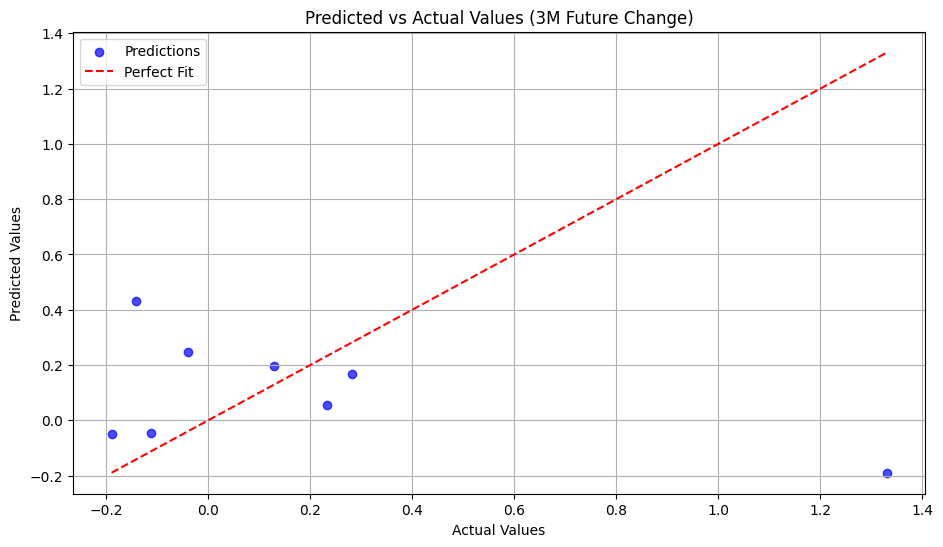

3M Future Change - R²: -0.6312
3M Future Change - MSE: 0.3489
3M Future Change - MAE: 0.3681


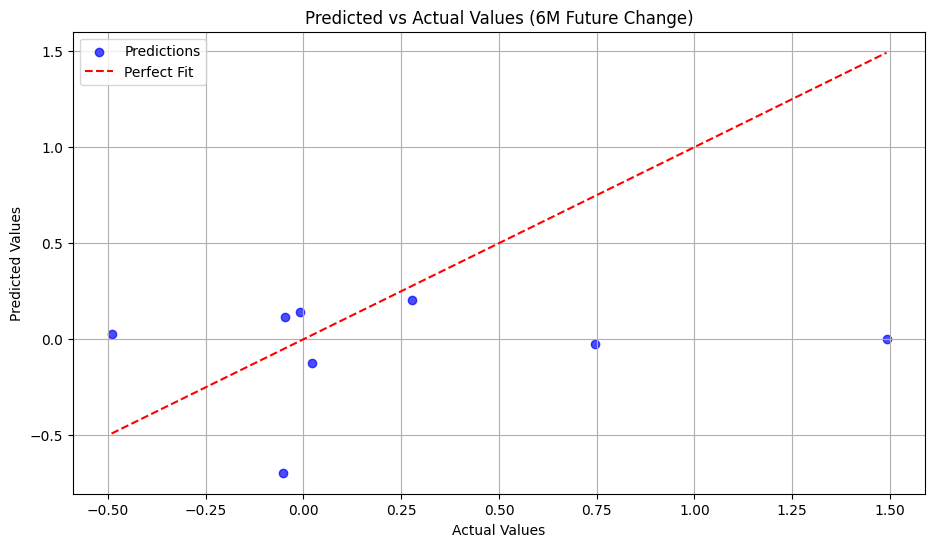

6M Future Change - R²: -0.3591
6M Future Change - MSE: 0.4476
6M Future Change - MAE: 0.4949


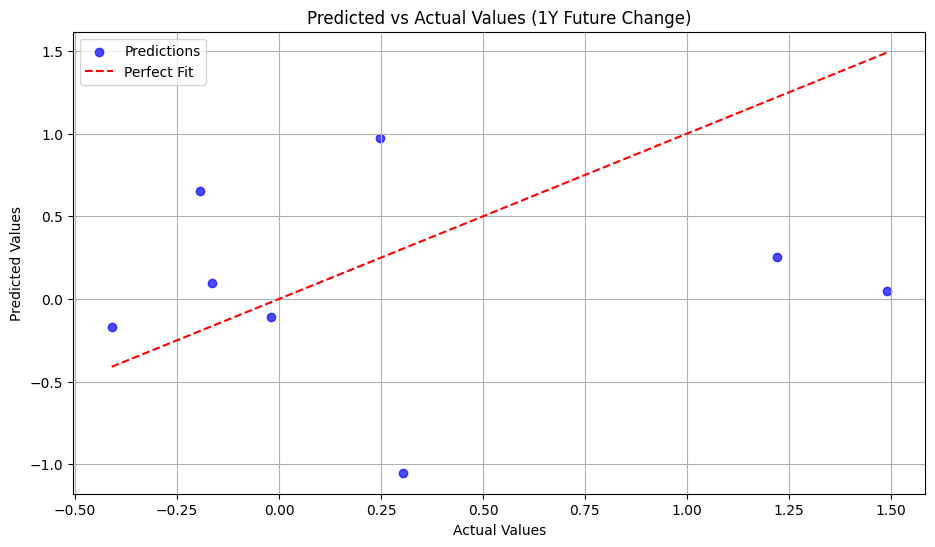

1Y Future Change - R²: -0.8672
1Y Future Change - MSE: 0.7769
1Y Future Change - MAE: 0.7404

Overall Scores:
Mean - R²: -0.6192
Mean - MSE: 0.5245
Mean - MAE: 0.5345


In [135]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [136]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [144]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0893079795170797


In [145]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*5, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Amortization Of Securities
- Cash Cash Equivalents And Federal Funds Sold
- Cash Flow From Discontinued Operation
- Cash Flowsfromusedin Operating Activities Direct
- Cash From Discontinued Financing Activities
- ...


In [142]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [143]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a8c968acf9d317b028.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
